Purpose of this notebook is to use LORA (aka Low Rank Adaptation method) and finetune

In [1]:
# !python -m pip install -q datasets peft evaluate

In [2]:
# !python -m pip uninstall -y pyarrow datasets ibis-framework

In [3]:
# !python -m pip install pyarrow>=15.0.0 datasets peft evaluate

In [4]:
# !python -m pip show pyarrow datasets

In [5]:
# !python -m pip install pyarrow>=15.0.0 datasets peft evaluate

In [6]:
from datasets import load_dataset, DatasetDict, Dataset

from transformers import (AutoTokenizer,
                         AutoConfig,
                         AutoModelForSequenceClassification,
                         DataCollatorWithPadding,
                         TrainingArguments,
                         Trainer)

from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig
import evaluate
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

/home/jupyter/new_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from torch.nn.functional import softmax

In [8]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'mps'
print(device)

cuda


#### Base Model (mobileBERT)

In [9]:
model_checkpoint = 'google/mobilebert-uncased'
id2label = {0: 'information_intent',
            1: 'yelp_intent',
            2: 'navigation_intent',
            3: 'travel_intent',
            4: 'purchase_intent',
            5: 'weather_intent',
            6: 'translation_intent',
            7: 'unknown'}
label2id = {label:id for id,label in id2label.items()}


# generate classification model from model chckpoints
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=8,
    id2label=id2label,
    label2id=label2id
)

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Load dataset

In [10]:
df = pd.read_csv("data/marco_train_v7.csv")
print(len(df))
print(df['target'].value_counts())
df.head(10)

201426
target
information_intent    120879
yelp_intent            33274
navigation_intent      14332
weather_intent         13749
purchase_intent         7892
travel_intent           6684
unknown                 2322
translation_intent      2294
Name: count, dtype: int64


,sequence,target
0,what is the benefits of six sigma process?,information_intent
1,cheap professional cleaning service,yelp_intent
2,house cleaners and apartment cleaning,yelp_intent
3,what define white as a race,information_intent
4,what is a nigp commodity code,information_intent
5,"Mrui, Hawai",travel_intent
6,wood floor buckling repair,yelp_intent
7,venereal disease meaning,information_intent
8,what is a single-subject or single-system design,information_intent
9,how to cite quotes from a book,information_intent


count    201426.000000
mean         28.749134
std          11.268303
min           3.000000
10%          16.000000
20%          19.000000
25%          21.000000
30%          22.000000
40%          25.000000
50%          28.000000
60%          31.000000
70%          34.000000
75%          35.000000
80%          37.000000
90%          43.000000
95%          48.000000
98%          54.000000
99%          59.000000
99.5%        65.000000
99.8%        78.000000
99.9%        91.575000
max         193.000000
Name: sequence, dtype: float64


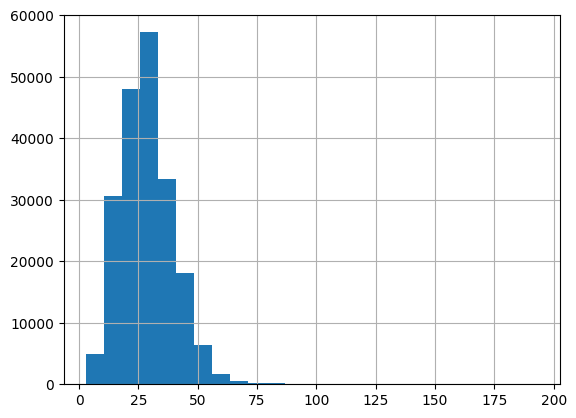

In [11]:
print(df['sequence'].apply(len).describe(percentiles=[.1, .2, .25, .3, .4, .5, .6, .7, .75, .8, .9, .95, .98, .99, .995, .998, .999]))
df['sequence'].apply(len).hist(bins=25);

In [12]:
pd.set_option('display.max_colwidth', 100)
df.loc[df['sequence'].apply(lambda text: len(text) > 64)]

,sequence,target
233,how many constitutional amendments have been ratified since its ratification ?,information_intent
253,which of the following protein classes are not found as membrane proteins?,information_intent
353,dilated ascending thoracic aorta and type b dissection definition,information_intent
363,which molecules show an appropriate number of bonds around each carbon atom?select the three tha...,information_intent
666,one difference between mitosis and meiosis is that cells entering meiosis,information_intent
...,...,...
200989,what kind of beauty is lord byron defining in she walks in beauty,information_intent
201133,which of the following is a fundamental consideration to examine when task organizing a force?,information_intent
201283,which css attribute would change an element's font color to blue?,information_intent
201393,"american continental insurance company aetna, customer care phone number",navigation_intent


In [13]:
# create tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)

token_lengths = []
for sequence in df['sequence'].values:
    tokens = tokenizer(sequence, truncation=False)['input_ids']  # Get tokenized input IDs
    token_lengths.append(len(tokens))

# Create a DataFrame for analysis
temp_df = pd.DataFrame({'sequence': df['sequence'].values, 'token_length': token_lengths})

# Display token lengths
print(temp_df)

# Optional: Analyze token lengths for deciding the best max_length
print(f"Max token length: {temp_df['token_length'].max()}")
print(f"Average token length: {temp_df['token_length'].mean()}")
print(f"90th percentile token length: {temp_df['token_length'].quantile(0.9)}")
print(f"95th percentile token length: {temp_df['token_length'].quantile(0.95)}")
print(f"98th percentile token length: {temp_df['token_length'].quantile(0.98)}")
print(f"99th percentile token length: {temp_df['token_length'].quantile(0.99)}")
print(f"99.5th percentile token length: {temp_df['token_length'].quantile(0.995)}")
print(f"99.9th percentile token length: {temp_df['token_length'].quantile(0.999)}")

del temp_df

/home/jupyter/new_env/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


                                          sequence  token_length
0       what is the benefits of six sigma process?            11
1              cheap professional cleaning service             6
2            house cleaners and apartment cleaning             8
3                      what define white as a race             8
4                    what is a nigp commodity code             9
...                                            ...           ...
201421          cheapest taqueria el amigo waltham            12
201422        how many micro bitcoins in a bitcoin            13
201423                             define pigments             5
201424             weather in crested butte in may             8
201425      where is the iberian peninsula located             8

[201426 rows x 2 columns]
Max token length: 55
Average token length: 8.108238261197661
90th percentile token length: 11.0
95th percentile token length: 13.0
98th percentile token length: 14.0
99th percentile token lengt

In [14]:
# Select only a sample from the actual data

sampling_percentages = {
    'information_intent': 1.0,   # 100% sampling for information_intent
    'yelp_intent': 1.0,          # 100% sampling for yelp_intent
    'weather_intent': 1.0,       # 100% sampling for weather_intent
    'navigation_intent': 1.0,    # 100% sampling for navigation_intent
    'purchase_intent': 1.0,      # 100% sampling for purchase_intent
    'translation_intent': 1.0,   # 100% sampling for translation_intent
    'travel_intent': 1.0,        # 100% sampling for travel_intent
    'unknown': 1.0               # 100% sampling for unknown
}

# Sample from each target group based on the defined percentages
sampled_df = df.groupby('target', group_keys=False).apply(
    lambda x: x.sample(frac=sampling_percentages.get(x.name, 1.0))
).reset_index(drop=True)

sampled_df['label'] = sampled_df['target'].map(label2id)
# sampled_df = sampled_df.rename(columns={'target': 'label'})

print(sampled_df['label'].value_counts())
print(f"Size of sampled_df = {len(sampled_df)}")
sampled_df.head()

label
0    120879
1     33274
2     14332
5     13749
4      7892
3      6684
7      2322
6      2294
Name: count, dtype: int64
Size of sampled_df = 201426


/var/tmp/ipykernel_287165/1383443563.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('target', group_keys=False).apply(


,sequence,target,label
0,what does a degree in public health do,information_intent,0
1,where is hochatown oklahoma,information_intent,0
2,what is the formula for frequency,information_intent,0
3,nfl patriots schedule,information_intent,0
4,define tundra climate,information_intent,0


In [15]:
# Step 1: Split the DataFrame into train and validation sets
train_df, val_df = train_test_split(sampled_df, test_size=0.05, random_state=42, stratify=sampled_df['label'])

# Step 2: Convert Pandas DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
val_dataset = Dataset.from_pandas(val_df, preserve_index=False)

# Step 3: Create a DatasetDict
dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset
})

# Step 4: Verify the structure of DatasetDict
print(dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['sequence', 'target', 'label'],
        num_rows: 191354
    })
    validation: Dataset({
        features: ['sequence', 'target', 'label'],
        num_rows: 10072
    })
})


In [16]:
train_df['label'].value_counts()

label
0    114835
1     31610
2     13615
5     13062
4      7497
3      6350
7      2206
6      2179
Name: count, dtype: int64

In [17]:
val_df['label'].value_counts()

label
0    6044
1    1664
2     717
5     687
4     395
3     334
7     116
6     115
Name: count, dtype: int64

#### Preprocess data

In [18]:


# add pad token if none exists
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))

# tokenize function
def tokenize_function(examples):
    # extract text
    text = examples["sequence"]

    # tokenize and truncate text
    tokenizer.truncation_side = "right"
    tokenized_inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,  # Pad the sequences to the longest in the batch
        max_length=64
    )
    return tokenized_inputs

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [19]:
tokenized_dataset = dataset_dict.map(tokenize_function, batched=True)
# tokenized_dataset = tokenized_dataset.map(fix_labels)
tokenized_dataset

Map: 100%|██████████| 10072/10072 [00:00<00:00, 26980.25 examples/s]


DatasetDict({
    train: Dataset({
        features: ['sequence', 'target', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 191354
    })
    validation: Dataset({
        features: ['sequence', 'target', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10072
    })
})

#### Evaluation Metrics

In [20]:
def compute_metrics(p):
    logits, labels = p
    predictions = np.argmax(logits, axis=1)
    # Combine metrics
    accuracy_metric = evaluate.load("accuracy")
    precision_metric = evaluate.load("precision")
    recall_metric = evaluate.load("recall")
    f1_metric = evaluate.load("f1")

    # Calculate metrics
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels, average="weighted")
    recall = recall_metric.compute(predictions=predictions, references=labels, average="weighted")
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")

    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"]
    }

In [21]:
# ### Evaluate untrained model

# text_list = [
#     'floor repair cost',
#     'denture fix',
#     'who is the us president',
#     'italian food',
#     'sandwiches in seattle',
#     'seattle weather',
#     'weather seattle',
#     'boston wether',
#     'Boston wether',
#     'weather boston',
#     'weather Boston',
#     'Weather Boston',
#     'weathr boston',
#     'seattle weathr',
#     'apple macbook price',
#     'sf sushi',
#     'sf ramen',
#     'seattle sushi',
#     'seattle ramen',
#     'sushi sf',
#     'ramen sf',
#     'chase bank login',
#     'passport application',
#     'walm',
#     'footbal',
#     'movers quote','its sushi', 'average house cleaning rates', 'fun things to do', 'foster gwin', 'go karts', 'facial', 'donuts',
#     'via carota', 'tomi jazz', 'mun korean steakhouse', 'la pecora bianca', 'birria tacos', 'bank of america', 'bungee fitness',
#     'allien', 'proposa', 'wather', 'big city', 'orlando bloom', 'banana', 'lenght',
# ]

# print("Untrained model predictions:")
# print("----------------------------")
# predictions = []
# logits_list = []
# for text in text_list:
#     inputs = tokenizer.encode(text, return_tensors="pt")
#     logits = model(inputs).logits
#     prediction = torch.argmax(logits, dim=1).item()
#     predictions.append(prediction)
#     print(text + " -> " + id2label[prediction])

#### Model finetuning with LoRA

In [22]:
peft_config = LoraConfig(task_type="SEQ_CLS",
                         r=16, # intrinsic rank of trainable weight matrix
                         lora_alpha=32, # similar to learning_rate
                         lora_dropout=0.01, # probability of dropout nodes
                         target_modules=['attention.self.query', 'attention.self.key']) # LoRA is applied to query & key layer


model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 200,712 || all params: 24,786,704 || trainable%: 0.8098


In [23]:
# for name, module in model.named_modules():
#     print(name)

#### Define hyper parameters and training arguments

In [24]:
from transformers import EarlyStoppingCallback

lr = 1e-4
batch_size = 16
num_epochs = 6

# training args
training_args = TrainingArguments(
    # output_dir=model_checkpoint + "-lora-intent-classification-v3",
    output_dir="mobilebert-uncased" + "-lora-intent-classification-v7",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    # warmup_steps=1000,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [25]:
trainer = Trainer(
    model=model, 
    args=training_args, # Hyperparamaters
    train_dataset=tokenized_dataset["train"], # training data
    eval_dataset=tokenized_dataset["validation"], # validation data
    tokenizer=tokenizer, # tokenizer
    data_collator=data_collator, # dynamic sequence padding
    compute_metrics=compute_metrics,  # model perfomance evaluation metric
    callbacks=[EarlyStoppingCallback(early_stopping_patience=4)]
)


In [26]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,33.990200,14.665943,0.916402,0.914308,0.916402,0.915002
2,79.863200,8.076523,0.936954,0.935874,0.936954,0.935775
3,79.019000,5.699135,0.946088,0.945333,0.946088,0.945508
4,27.499600,1.473685,0.942415,0.942223,0.942415,0.942057
5,13.533700,0.768880,0.948967,0.948049,0.948967,0.948176
6,2.958600,0.327371,0.950556,0.949603,0.950556,0.949863


TrainOutput(global_step=71760, training_loss=938.2985988178913, metrics={'train_runtime': 7766.6143, 'train_samples_per_second': 147.828, 'train_steps_per_second': 9.24, 'total_flos': 5739157493809920.0, 'train_loss': 938.2985988178913, 'epoch': 6.0})

In [27]:
# trainer.model

In [29]:
text_list = [
    'floor repair cost',
    'denture implant cost',
    'who is the us president',
    'italian food',
    'sandwiches in seattle',
    'seattle weather',
    'weather seattle',
    'boston wether',
    'Boston wether',
    'weather boston',
    'weather Boston',
    'Weather Boston',
    'weathr boston',
    'seattle weathr',
    'apple macbook price',
    'sf sushi',
    'sf ramen',
    'seattle sushi',
    'seattle ramen',
    'sushi sf',
    'ramen sf',
    'chase bank login',
    'passport application',
    'movers quote','its sushi', 'average house cleaning rates', 'fun things to do', 'foster gwin', 'go karts', 'facial', 'donuts',
    'via carota', 'tomi jazz', 'mun korean steakhouse', 'la pecora bianca', 'birria tacos', 'bank of america', 'bungee fitness',
    'best smartphone',
    'sushi sf',
    'ramen sf',
    'sushi',
    'ramen',
    'footbal',
    'breaking bad',
    'walm',
    'top gun maverick',
    'clean pape',
    'paws scor',
    'cristiano ronaldo',
    'fastfood',
    'inte',
    'potatos',
    'visionare',
    'allien',
    'proposa',
    'wather',
    'big city',
    'orlando bloom',
    'banana',
    'lenght',
    'cafe ca',
    'arcade',
    'bagels',
    'bank of america',
    'bowling',
    'cupcakes',
    'electrician', 'electricians', 'best electrician', 'best electricians', 'popular electricians',
    'karaoke',
    'korean bbq',
    'laser tag',
    'pilates',
    'sports bar',
]

In [30]:
trainer.model.eval()
with torch.no_grad():
    for text in text_list:
        inputs = tokenizer.encode(text, return_tensors="pt").to(device)
        logits = trainer.model(inputs).logits
        prediction = torch.argmax(logits, dim=1).item()
        probabilities = softmax(logits, dim=1)
        prediction_probability = probabilities[0, prediction].item()
        print(text + " -> " + id2label[prediction] + ": ", prediction_probability)

floor repair cost -> yelp_intent:  0.9999886751174927
denture implant cost -> yelp_intent:  0.9304097890853882
who is the us president -> information_intent:  0.9999076128005981
italian food -> yelp_intent:  0.9821021556854248
sandwiches in seattle -> yelp_intent:  0.9847724437713623
seattle weather -> weather_intent:  0.9998944997787476
weather seattle -> weather_intent:  0.9999699592590332
boston wether -> weather_intent:  0.8431703448295593
Boston wether -> weather_intent:  0.8431703448295593
weather boston -> weather_intent:  0.999985933303833
weather Boston -> weather_intent:  0.999985933303833
Weather Boston -> weather_intent:  0.999985933303833
weathr boston -> weather_intent:  0.9999779462814331
seattle weathr -> weather_intent:  0.9999904632568359
apple macbook price -> purchase_intent:  0.9962782263755798
sf sushi -> yelp_intent:  0.9695122838020325
sf ramen -> yelp_intent:  0.9479253888130188
seattle sushi -> yelp_intent:  0.9816707372665405
seattle ramen -> yelp_intent:  0.

In [31]:
!ls -lh mobilebert-uncased-lora-intent-classification-v7/checkpoint-71760

total 3.4M
-rw-r--r-- 1 jupyter jupyter 5.0K Nov 29 20:54 README.md
-rw-r--r-- 1 jupyter jupyter  706 Nov 29 20:54 adapter_config.json
-rw-r--r-- 1 jupyter jupyter 798K Nov 29 20:54 adapter_model.safetensors
-rw-r--r-- 1 jupyter jupyter 1.7M Nov 29 20:54 optimizer.pt
-rw-r--r-- 1 jupyter jupyter  14K Nov 29 20:54 rng_state.pth
-rw-r--r-- 1 jupyter jupyter 1.1K Nov 29 20:54 scheduler.pt
-rw-r--r-- 1 jupyter jupyter  125 Nov 29 20:54 special_tokens_map.json
-rw-r--r-- 1 jupyter jupyter 695K Nov 29 20:54 tokenizer.json
-rw-r--r-- 1 jupyter jupyter 1.3K Nov 29 20:54 tokenizer_config.json
-rw-r--r-- 1 jupyter jupyter  28K Nov 29 20:54 trainer_state.json
-rw-r--r-- 1 jupyter jupyter 5.2K Nov 29 20:54 training_args.bin
-rw-r--r-- 1 jupyter jupyter 227K Nov 29 20:54 vocab.txt


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


#### Load the LoRA model from checkpoint after training

In [32]:
id2label = {0: 'information_intent',
            1: 'yelp_intent',
            2: 'navigation_intent',
            3: 'travel_intent',
            4: 'purchase_intent',
            5: 'weather_intent',
            6: 'translation_intent',
            7: 'unknown'}
label2id = {label:id for id,label in id2label.items()}


output_dir = "mobilebert-uncased-lora-intent-classification-v7/checkpoint-71760"

# Load the tokenizer (from the output directory)
tokenizer = AutoTokenizer.from_pretrained(output_dir, return_tensors="pt", padding="max_length", truncation=True, max_length=64)

# Load the base model from the original checkpoint (base pre-trained model)
base_model = AutoModelForSequenceClassification.from_pretrained('google/mobilebert-uncased', num_labels=8, id2label=id2label, label2id=label2id)

# Load the LoRA configuration and model
peft_config = PeftConfig.from_pretrained(output_dir)
lora_model = PeftModel.from_pretrained(base_model, output_dir)

# Step 3: Save the combined model to a directory
save_directory = "tmp/mobilebert_lora_combined_model/"
lora_model.save_pretrained(save_directory)  # Save base model + LoRA weights

# Now the `lora_model` contains both the base model and the LoRA weights.
lora_model.eval()

# Example inference
inputs = tokenizer(["looking for home cleaning "], return_tensors="pt")
outputs = lora_model(**inputs)
logits = outputs.logits
print(logits)


prediction = torch.argmax(logits, dim=1).item()
print(prediction, id2label[prediction])
probabilities = torch.softmax(logits, dim=1)
rounded_probabilities = torch.round(probabilities)
print(rounded_probabilities)

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tensor([[ -3.1562,   8.0883,  -4.3224, -10.1520,   1.9380,  -7.3656, -11.7488,
          -5.7316]], grad_fn=<AddmmBackward0>)
1 yelp_intent
tensor([[0., 1., 0., 0., 0., 0., 0., 0.]], grad_fn=<RoundBackward0>)


In [33]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from peft import PeftModel, PeftConfig

# Step 1: Load the base model (DistilBERT)
base_model = AutoModelForSequenceClassification.from_pretrained('google/mobilebert-uncased', num_labels=8, id2label=id2label, label2id=label2id)

# Step 2: Load the LoRA adapter weights
output_dir = "mobilebert-uncased-lora-intent-classification-v7/checkpoint-71760"
peft_config = PeftConfig.from_pretrained(output_dir)
lora_model = PeftModel.from_pretrained(base_model, output_dir)

# Step 3: Merge LoRA weights into the base model
# After this, the model will have both base and LoRA weights applied
merged_model = lora_model.merge_and_unload()

# Step 4: Save the full model (base model + LoRA weights)
save_directory = "tmp/mobilebert_lora_combined_model/"
merged_model.save_pretrained(save_directory)
tokenizer = AutoTokenizer.from_pretrained(output_dir)  # Load the tokenizer
tokenizer.save_pretrained(save_directory)  # Save the tokenizer


Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


('tmp/mobilebert_lora_combined_model/tokenizer_config.json',
 'tmp/mobilebert_lora_combined_model/special_tokens_map.json',
 'tmp/mobilebert_lora_combined_model/vocab.txt',
 'tmp/mobilebert_lora_combined_model/added_tokens.json',
 'tmp/mobilebert_lora_combined_model/tokenizer.json')

In [34]:
# !huggingface-cli whoami

In [36]:
merged_model_dir = "tmp/mobilebert_lora_combined_model"
merged_repo_id = "Mozilla/mobilebert-uncased-finetuned-LoRA-intent-classifier"  

merged_model.push_to_hub(merged_repo_id)
tokenizer.push_to_hub(merged_repo_id)

model.safetensors: 100%|██████████| 98.5M/98.5M [00:02<00:00, 34.5MB/s]


CommitInfo(commit_url='https://huggingface.co/Mozilla/mobilebert-uncased-finetuned-LoRA-intent-classifier/commit/038a864771e9afe4c0c9d983f18fc0a9d812bc22', commit_message='Upload tokenizer', commit_description='', oid='038a864771e9afe4c0c9d983f18fc0a9d812bc22', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Mozilla/mobilebert-uncased-finetuned-LoRA-intent-classifier', endpoint='https://huggingface.co', repo_type='model', repo_id='Mozilla/mobilebert-uncased-finetuned-LoRA-intent-classifier'), pr_revision=None, pr_num=None)